In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Levenshtein import distance as lev_distance
sns.set(style='white', font_scale=1.25)

## Imports

In [2]:
counts_kind = pd.read_csv('data/counts_kind.csv', index_col=0)
counts_current = pd.read_csv('data/counts_current.csv', index_col=0)
counts_future = pd.read_csv('data/counts_future.csv', index_col=0)
institutions = pd.read_csv('data/institutions.csv', index_col=0)

In [3]:
total_responses = counts_current.shape[0]
print('Total responses: {}'.format(total_responses))
print('Total unique emails: {}'.format(len(institutions['institution'].value_counts())))

Total responses: 450
Total unique emails: 88


## Locations

In [4]:
print(institutions['institution'].dropna().value_counts().index)

Index(['University Medical Center Utrecht', 'Stanford University',
       'University of California, Berkeley',
       'University of California, San Diego', 'Aix-Marseille Université',
       'The Donders Institute', 'Mayo Clinic', 'Universität Salzburg',
       'Machquarie University', 'University Medical Center, Maastricht',
       'University of Geneva', 'San Diego State University',
       'Oxford University', 'University of Colorado, Boulder',
       'University of California, Irvine', 'University of Glasgow',
       'Universidad Polytecnica de Madrid', 'University of Cardiff',
       'Compute Ontario', 'University of Montreal', 'EPFL Research',
       'Universita degli Studi di Genova', 'Duke University',
       'Starkey Research', 'University of Texas, Austin',
       'Florida Atlantic University', 'University of Lincoln',
       'University of New Mexico', 'Polytechnic University, UK',
       'University of Tartu', 'Macquarie University', 'University of Illinois',
       'qEEG

In [5]:
import geopandas as gpd
import geoplot as gpt
from shapely.geometry import Point
from fiona.crs import from_epsg
from quilt.data.ResidentMario import geoplot_data

In [6]:
points = []
for ix, irow in institutions.iterrows():
    if not isinstance(irow['point'], str):
        this_point = None
    else:
        this_point = Point(irow.longitude, irow.latitude)
    points.append(this_point)
institutions['geometry'] = points

In [7]:
df = gpd.GeoDataFrame(institutions)
df.crs = from_epsg(4326)

In [8]:
earth = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
continental_usa = gpd.read_file(geoplot_data.contiguous_usa())
df = df.dropna().to_crs(earth.crs)

([], <a list of 0 Text yticklabel objects>)

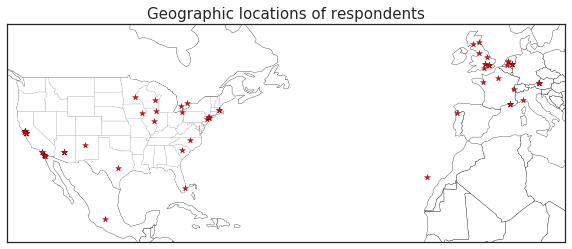

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = earth.plot(ax=ax, facecolor='w', edgecolor='k')
ax = continental_usa.plot(ax=ax, facecolor='w', edgecolor='gray', linewidth=.2)
df.plot(ax=ax, color='red', markersize=40, marker='*', edgecolor='k', linewidth=.2)
ax.set(xlim=[-127, 20], ylim=[15, 60], title="Geographic locations of respondents")
plt.xticks([])
plt.yticks([])

## Counts current vs. future

In [10]:
# Merge and create percentage matrix
counts_all = pd.merge(counts_current, counts_future, left_index=True, right_index=True,
                      suffixes=('_current', '_future'))
counts_all = counts_all[counts_all.columns.drop_duplicates()]
index_current = [ii for ii in counts_all.columns.values if ii.endswith('_current')]
index_future = [ii for ii in counts_all.columns.values if ii.endswith('_future')]

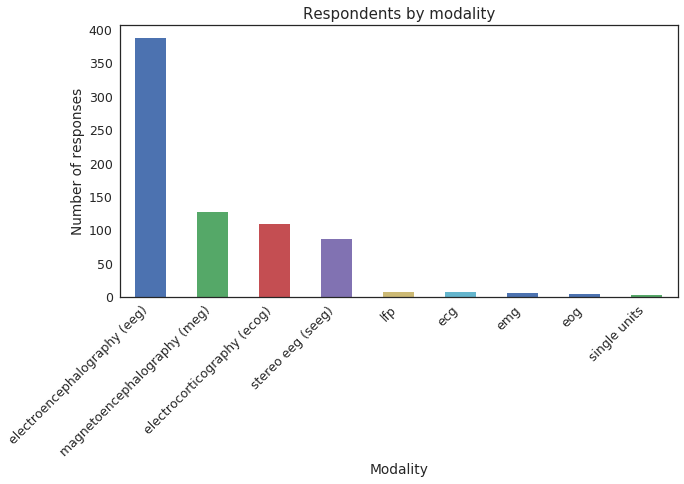

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = counts_kind.sum(0).plot.bar()
ax.set(xlabel="Modality", ylabel="Number of responses", title="Respondents by modality")
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

In [12]:
# Calculate percent using a format now that'd use a format in future
counts_perc = pd.DataFrame()
for irow in index_current:
    total_row = counts_all[irow].sum()
    new_row = irow.replace('_current', '')
    for icol in index_future:
        new_col = icol.replace('_future', '')
        total_both = np.sum((counts_all[irow] == 1) & (counts_all[icol] == 1))
        counts_perc.loc[new_row, new_col] = (total_both / total_row) * 100
counts_perc.columns.name = 'Future'
counts_perc.index.name = 'Current'

# Rearrange so all columns/rows line up
counts_perc = counts_perc.loc[counts_perc.columns]

[Text(48,0.5,'That WOULD share...'),
 Text(0.5,48,'Percent respondents using...'),
 Text(0.5,1,'Respondent willingness to use new formats')]

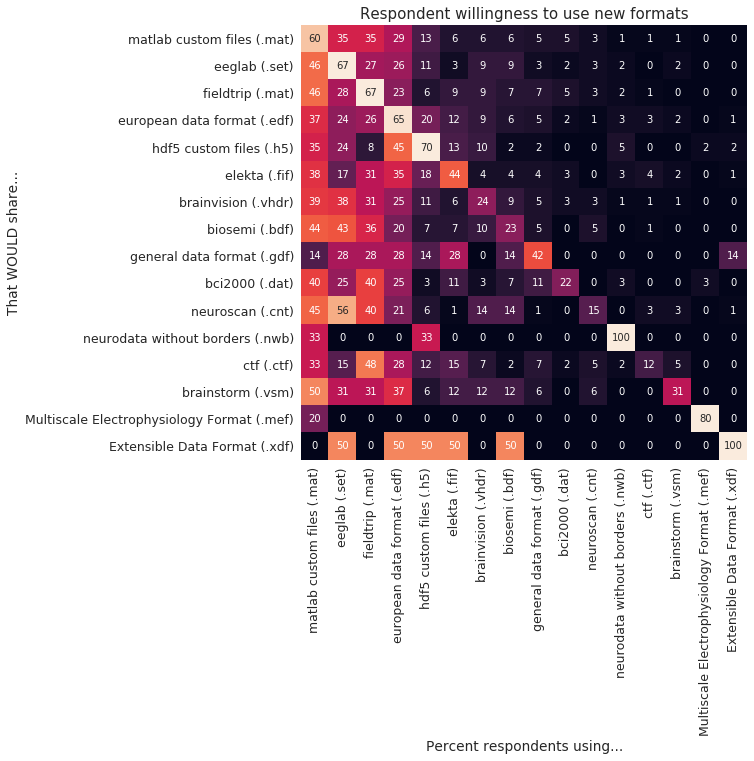

In [13]:
# Percent of people currently using each row that'd use each column
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(counts_perc.astype(int), robust=True, annot=True, fmt='d', cbar=False)
ax.set(ylabel="That WOULD share...", xlabel="Percent respondents using...", title="Respondent willingness to use new formats")

# Visualizations

In [14]:
def counts_percentage_df(df):
    """Calculate for each column the % simultaneous counts with each row."""
    counts_perc = pd.DataFrame()
    # Percentage of people using this format
    for irow in df.columns:
        # Total people using this column
        total_col = df[irow].sum()
        # That also use this format
        for icol in df.columns:
            # Total people using both this column and that column
            total_both = sum((df[icol] == 1) & (df[irow] == 1))
            counts_perc.loc[icol, irow] = int((total_both / total_col) * 100) 
    counts_perc = counts_perc.loc[counts_perc.columns, :]
    return counts_perc.astype(int)

In [15]:
print('Total formats given:\n', counts_current.columns.drop_duplicates())

Total formats given:
 Index(['matlab custom files (.mat)', 'eeglab (.set)', 'brainvision (.vhdr)',
       'biosemi (.bdf)', 'fieldtrip (.mat)', 'european data format (.edf)',
       'elekta (.fif)', 'neuroscan (.cnt)', 'ctf (.ctf)',
       'hdf5 custom files (.h5)', 'micromed (.trc)', 'bci2000 (.dat)',
       'neuralynx (.ncs)', 'brainstorm (.vsm)', 'bti / 4d neuroimaging (.4d)',
       'yokogawa / kit (.kit)', 'general data format (.gdf)',
       'Multiscale Electrophysiology Format (.mef)',
       'neurodata without borders (.nwb)', 'tmsi (.poly5)',
       'Extensible Data Format (.xdf)', 'EGI (.raw)'],
      dtype='object')


[Text(66,0.5,'That also use...'),
 Text(0.5,66,'Percent using...'),
 Text(0.5,1,'How often formats are used together')]

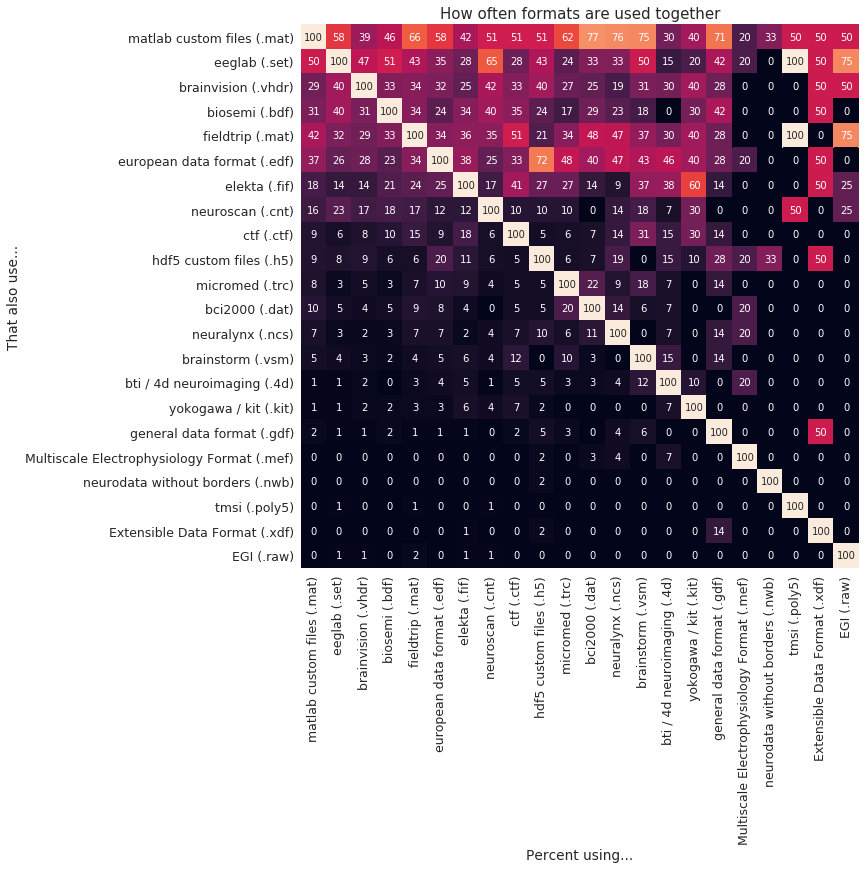

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
counts_perc_current = counts_percentage_df(counts_current)
sns.heatmap(counts_perc_current, annot=True, fmt='d', cbar=False)
ax.set(ylabel="That also use...", xlabel="Percent using...", title="How often formats are used together")

[Text(66,0.5,'That also suggest...'),
 Text(0.5,66,'Percent suggesting...'),
 Text(0.5,1,'How often formats are suggested for sharing together.')]

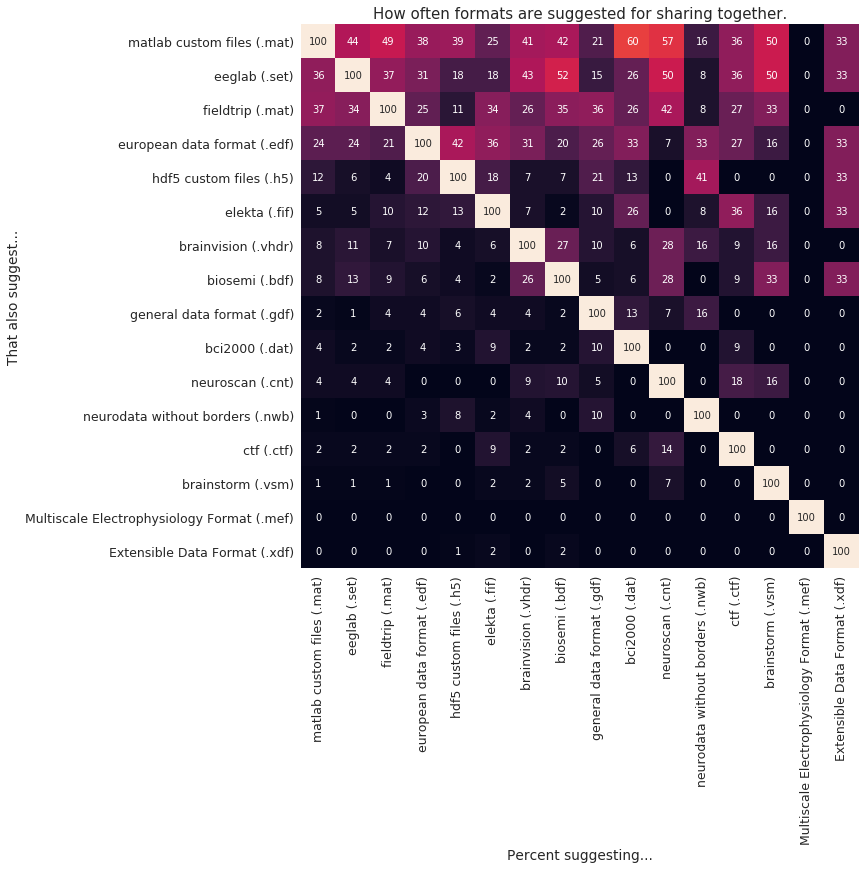

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
counts_perc_future = counts_percentage_df(counts_future)
sns.heatmap(counts_perc_future, annot=True, fmt='d', cbar=False)
ax.set(ylabel="That also suggest...", xlabel="Percent suggesting...", title="How often formats are suggested for sharing together.")

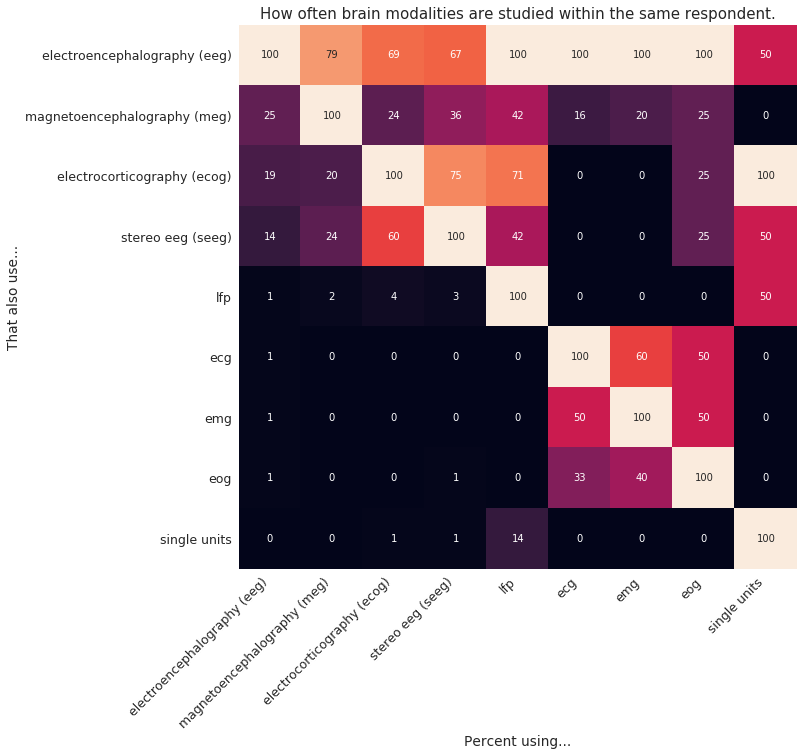

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
counts_perc_kind = counts_percentage_df(counts_kind)
sns.heatmap(counts_perc_kind, annot=True, fmt='d', cbar=False)
ax.set(ylabel="That also use...", xlabel="Percent using...", title="How often brain modalities are studied within the same respondent.")
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

# Modality-specific format use

In [19]:
exclude_formats = ['matlab custom files (.mat)', 'hdf5 custom files (.h5)']
# exclude_formats = []

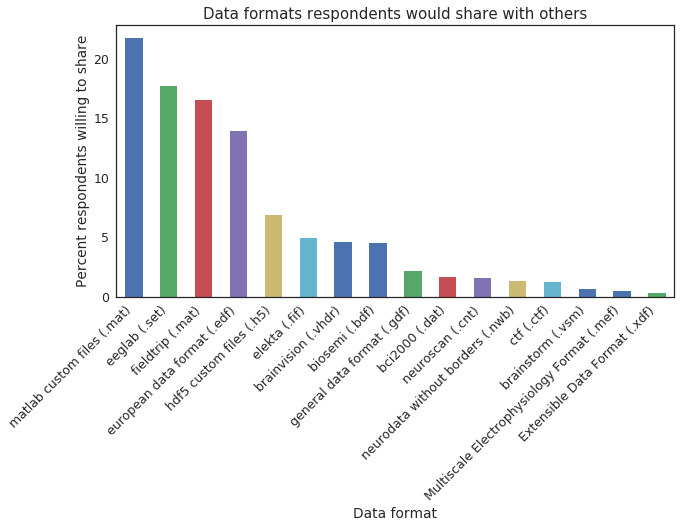

In [20]:
counts_future_all = counts_future.sum(0) 
counts_future_all /= counts_future_all.sum()
counts_future_all *= 100

fig, ax = plt.subplots(figsize=(10, 5))
ax = counts_future_all.plot.bar()
ax.set(xlabel="Data format", ylabel="Percent respondents willing to share", title="Data formats respondents would share with others")
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment="right");

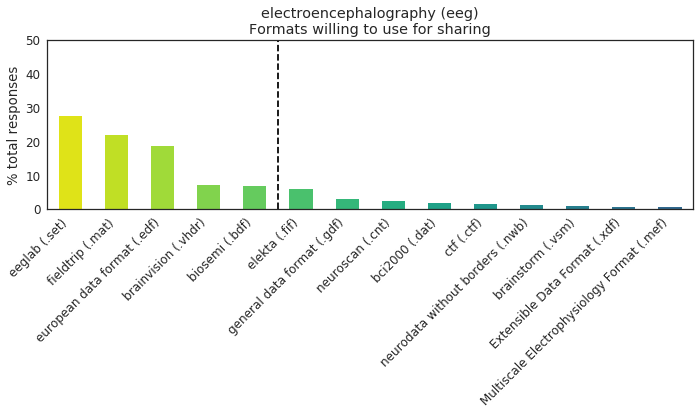

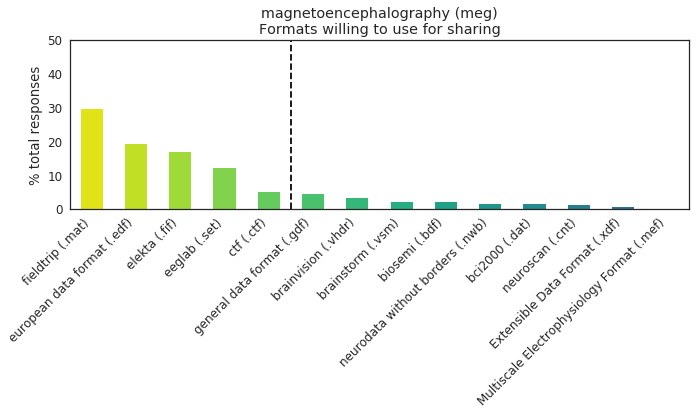

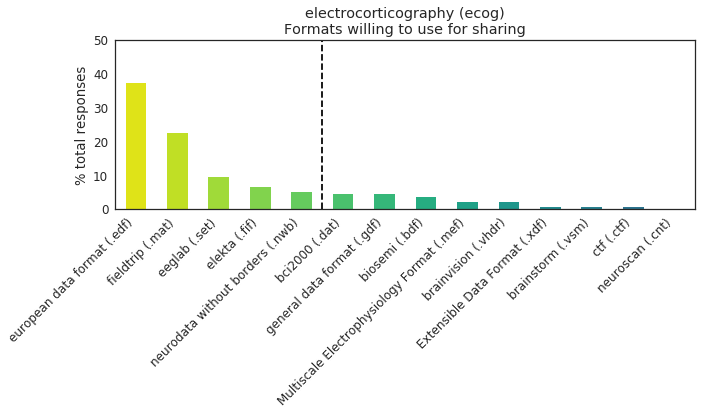

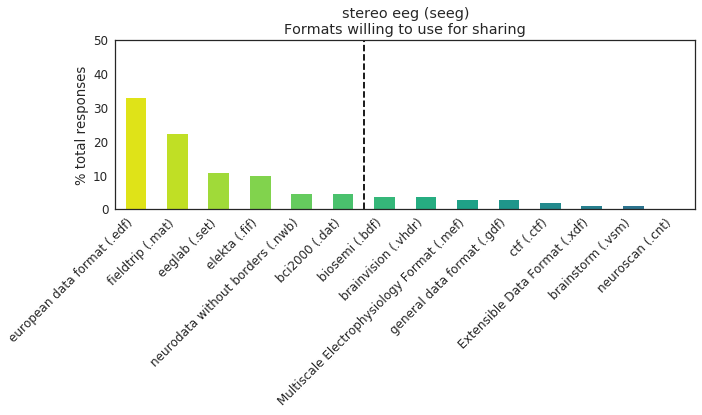

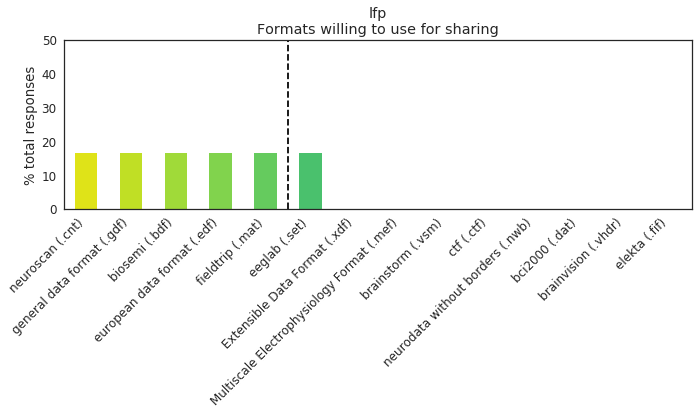

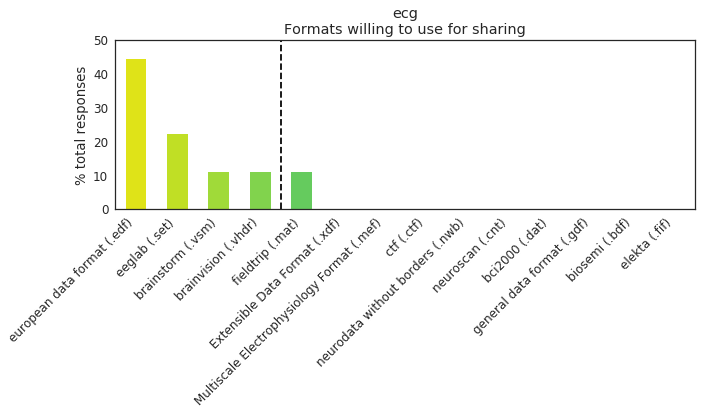

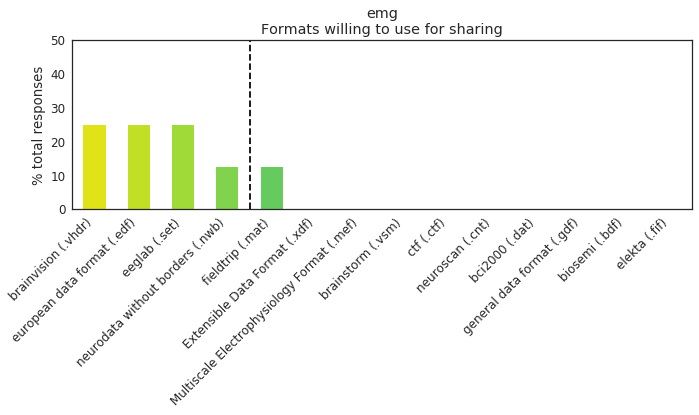

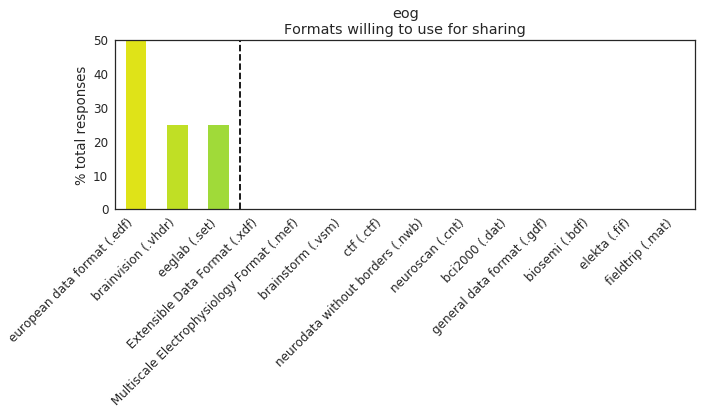

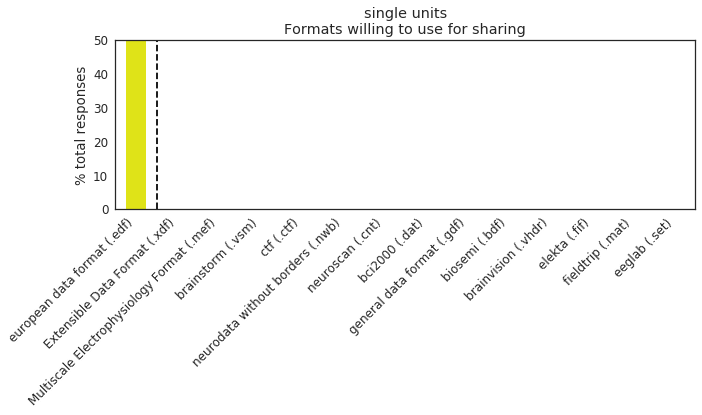

In [21]:
top_counts_future = {}
sns.set(font_scale=1.2, style='white', palette=sns.color_palette('viridis_r', n_colors=20))
for kind in counts_kind.columns:
    this_kind = counts_kind[counts_kind[kind] > 0]
    this_uid = this_kind.index.values
    this_current = counts_current.query('uid in @this_uid').sum(0)
    this_future = counts_future.query('uid in @this_uid').sum(0)
    
    # Remove fields we don't want to include
    this_current = this_current[[ii for ii in this_current.index if ii not in exclude_formats]]
    this_future = this_future[[ii for ii in this_future.index if ii not in exclude_formats]]

    this_current = this_current / this_current.sum() * 100
    this_future = this_future / this_future.sum() * 100
    
    # Sort by future
    this_future = this_future.sort_values(ascending=False)
    this_current = this_current[this_future.index]
    
    cumulative_future = this_future.cumsum()
    ix_cut = np.where(cumulative_future > 80)[0][0]
    top_counts_future[kind] = cumulative_future.index[:ix_cut].tolist()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_kind = this_future
    plot_kind.plot.bar(ax=ax)
    ax.axvline(ix_cut + .5, ls='--', color='k')
    ax.set(title='{}\nFormats willing to use for sharing'.format(kind))
    plt.setp(ax, ylim=[0, 50], ylabel='% total responses')
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()

## Cross-modality uses

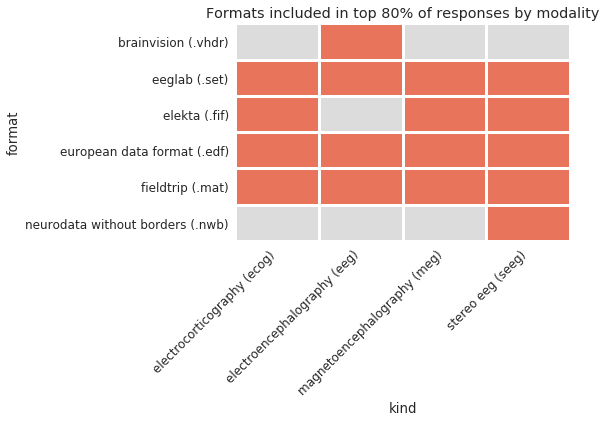

In [22]:
use_keys = ['stereo eeg (seeg)', 'electroencephalography (eeg)', 'magnetoencephalography (meg)','electrocorticography (ecog)']

data = []
for key, vals in top_counts_future.items():
    for val in vals:
        data.append((key, val))
data = pd.DataFrame(data, columns=['kind', 'format'])
data = data.query('kind in @use_keys').sort_values('format')
data['values'] = 1

data = data.pivot(index='format', columns='kind', values='values')
data = data.fillna(0)
ax = sns.heatmap(data, lw=2, cmap=plt.cm.coolwarm, vmin=-1.5, vmax=1.5, cbar=False)
ax.set(title="Formats included in top 80% of responses by modality")
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');